# 95-891 Homework 2
Blaine Perry

### Import the necessary packages

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#  1: Read the data into a pandas dataframe and perform general data cleaning

In [3]:
# Read in the tweet dataa
df = pd.read_csv("hw2.csv")

# Split the sentiment out into separate columns
df[['Positive Sentiment', 'Negative Sentiment']] = df['Sentiment'].str.split(' ', expand=True)

#convert the datatypes appropriately
df['Positive Sentiment'] = pd.to_numeric(df['Positive Sentiment'])
df['Negative Sentiment'] = pd.to_numeric(df['Negative Sentiment'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  #TODO: check and see if this is local or GMT
df['hour'] = pd.to_numeric(df['Timestamp'].dt.hour)
df['#Retweets'] = pd.to_numeric(df['#Retweets'])
df['#Favorites'] = pd.to_numeric(df['#Favorites'])
df['#Friends'] = pd.to_numeric(df['#Friends'])
df['#Followers'] = pd.to_numeric(df['#Followers'])

# create a helper function to count the number of mentions and hashtags in a column
def count_instances(x):
    if str(x)=="null;":
        return 0
    else:
        return len(str(x).split(" "))

df['num_mentions']=pd.to_numeric(df["Mentions"].apply(count_instances))
df['num_hashtags'] = pd.to_numeric(df['Hashtags'].apply(count_instances))

#drop unnecessary columns
df.drop(['URLs', 'Timestamp', 'Entities', 'Sentiment', 'Mentions', 'Hashtags'], axis=1, inplace=True)

# Confirm there is no missing data
assert(df.isna().any(axis = 1).sum() == 0)

df.head()

,Tweet ID,Username,#Followers,#Friends,#Retweets,#Favorites,Positive Sentiment,Negative Sentiment,hour,num_mentions,num_hashtags
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,619,770,0,0,2,-1,22,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,36365,19344,13,17,1,-4,22,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,5018,1933,0,0,2,-1,22,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,2219,971,0,0,2,-1,22,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,9009,4943,26,89,2,-1,22,0,1


# 2: EDA

## a) Follower, Friend, and Favorites Histograms

Text(0.5, 1.0, 'Follower Histogram')

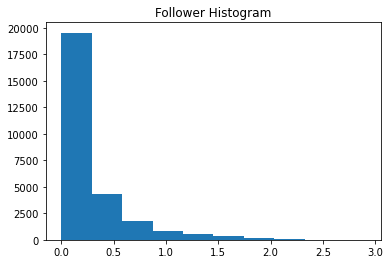

In [4]:
plt.hist(df['#Followers'].value_counts().apply(np.log10),bins=10)
title = 'Follower Histogram'
plt.title(title)

Text(0.5, 1.0, 'Friends Histogram')

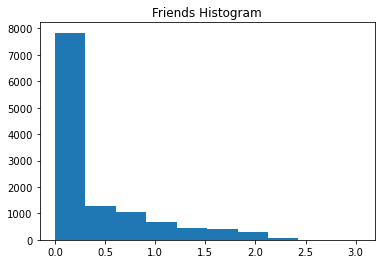

In [5]:
plt.hist(df['#Friends'].value_counts().apply(np.log10),bins=10)
title = 'Friends Histogram'
plt.title(title)

Text(0.5, 1.0, 'Favorites Histogram')

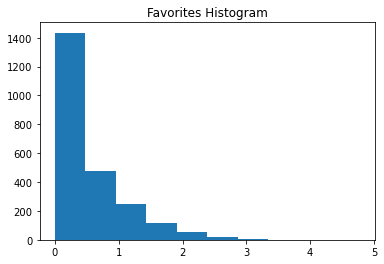

In [6]:
plt.hist(df['#Favorites'].value_counts().apply(np.log10),bins=10)
title = 'Favorites Histogram'
plt.title(title)

## b) Correlation Matrix

In [7]:
pd.DataFrame(df, columns=['#Retweets', '#Followers', '#Friends', '#Favorites', 'Positive Sentiment', 'Negative Sentiment']).corr()

,#Retweets,#Followers,#Friends,#Favorites,Positive Sentiment,Negative Sentiment
#Retweets,1.000000,0.134503,0.026502,0.890328,0.000433,-0.010565
#Followers,0.134503,1.000000,0.011337,0.172158,-0.027071,0.008711
#Friends,0.026502,0.011337,1.000000,0.017877,-0.000555,-0.007891
#Favorites,0.890328,0.172158,0.017877,1.000000,0.002533,-0.003889
Positive Sentiment,0.000433,-0.027071,-0.000555,0.002533,1.000000,-0.039849
Negative Sentiment,-0.010565,0.008711,-0.007891,-0.003889,-0.039849,1.000000


# c) What do these plots and correlation matrix signify?

The plots show that the data are skewed.  That is, most data points have 0 friends, followers, or favorites.
the correlation plot shows how the data are related, for example, the correlation between #Retweets and #Favorites 0.89.  This indicates that #Retweets is highly correlated with #Favorites.  The more retweets, the more favorites and vice versa.

# d) What do the signs before the correlation magnitudes signify?

They signify in which way the data are correlated.  A positive indicates that as one increases the other increases, a negative indicates that as one increases the other decreases.

# e) If a feature shows 0 correlation to #Retweets, does that mean it could not contribute to prediction?

This is only partially true.  A feature with 0 correlation means that the status of this feature linear relationship with the other.  These variables could be involved in a two way interaction (ex: the combination of a and b is correlated with c, when a is uncorrelated with c).  The feature could also have a nonlinear relationship which would not be captured with this method.

# 3: Split the data into train and test sets

In [8]:
train_data = df[:80000]
test_data = df[80000:]

#train inputs and targets
x_train = train_data[['#Followers', '#Friends', '#Favorites', 'Positive Sentiment', 'Negative Sentiment', 'hour', 'num_mentions', 'num_hashtags']]
y_train = train_data['#Retweets']

#test inputs and targets
x_test = test_data[['#Followers', '#Friends', '#Favorites', 'Positive Sentiment', 'Negative Sentiment', 'hour', 'num_mentions', 'num_hashtags']]
y_test = test_data['#Retweets']


#scale the data just to see if it matters
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)

x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

# Create the regressors

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define a helper function to evaluate performance
def evaluate(model, features, labels):
    predictions = model.predict(features)
    errors = abs(predictions - labels)
    print('Mean Absolute Error: {:0.4f} degrees.'.format(np.mean(errors)))

# Create the parameter grid
param_grid = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [5, 10, 50]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           scoring = 'neg_mean_absolute_error', cv = 3,
                           n_jobs = -1, verbose = 2)

# Use grid search to find the best RF regressor

In [10]:
# Perform grid search on the data
rf_grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20], 'max_features': [2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [5, 10, 50]},
             scoring='neg_mean_absolute_error', verbose=2)

# Evaluate the best RF

In [11]:
best_rf = rf_grid_search.best_estimator_
evaluate(best_rf, x_test, y_test)

Mean Absolute Error: 15.8957 degrees.


### Do the same for the scaled data

In [12]:
# Perform grid search on the data
rf_grid_search.fit(x_train_scale, y_train)
best_rf_scaled = rf_grid_search.best_estimator_
evaluate(best_rf, x_test_scale, y_test)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mean Absolute Error: 29.8786 degrees.


# View feature importance

In [13]:
# Get numerical feature importances
importance = list(best_rf.feature_importances_)

# List of tuples with variable and importance
feature_importance = [(feature, round(importance, 2)) for feature, importance in zip(list(x_train.columns), importance)]

# Sort the feature importance
feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {:.3f}'.format(*pair)) for pair in feature_importance];

Variable: #Favorites           Importance: 0.860
Variable: #Followers           Importance: 0.080
Variable: #Friends             Importance: 0.030
Variable: hour                 Importance: 0.020
Variable: Positive Sentiment   Importance: 0.010
Variable: Negative Sentiment   Importance: 0.010
Variable: num_mentions         Importance: 0.010
Variable: num_hashtags         Importance: 0.000


Here we can see that most of the variables are unimportant.  The most important by far is #Favorites.

# Linear Regression

In [14]:
from sklearn.linear_model import Lasso

# Create the parameter grid
param_grid = {'alpha':np.logspace(-3, 3, 7)}

# Create a based model
lasso = Lasso()

# Instantiate the grid search model
lasso_grid_search = GridSearchCV(estimator = lasso, param_grid = param_grid,
                           scoring = 'neg_mean_absolute_error', cv = 3,
                           n_jobs = -1, verbose = 2)

# Use grid search to find best regressor

In [15]:
# Perform grid search on the data
lasso_grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='neg_mean_absolute_error', verbose=2)

# Evaluate the best regressor

In [16]:
best_lasso = lasso_grid_search.best_estimator_
evaluate(best_lasso, x_test, y_test)

Mean Absolute Error: 17.3089 degrees.


### Do the same for the scaled data

In [17]:
lasso_grid_search.fit(x_train_scale, y_train)
best_lasso_scaled = lasso_grid_search.best_estimator_
evaluate(best_lasso, x_test_scale, y_test)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Mean Absolute Error: 30.4031 degrees.


# 6: Compare the two regression methods, what evaluation metrics are appropriate?

I chose to evaluate the models using Mean Absolute Error, although mean squared error would also be appropriate.  With this, I found that the unscaled RF was the best, with a MAE of 15.89.